## Machine Learning Models

**Imports & Reading In Data**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import (make_scorer, accuracy_score,
                             classification_report, precision_score,
                             recall_score, f1_score, confusion_matrix,
                             roc_auc_score, mean_squared_error,
                             mean_absolute_error, r2_score, roc_curve, auc)
from functions import (compute_rolling_stats,
                       cross_validation_report_classifcation, expected_outcome,
                       cross_val_report_lin_reg)

from plotting_functions import annotate_bars, hide_spines

In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
plt.style.use('data/deeplearning.mplstyle')
%config InlineBackend.figure_format = 'svg'
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_blue = default_colors[0]

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
odds_df = pd.read_csv('data/odds.csv')
matches_ratings = pd.read_csv('data/matches_with_attributes.csv', index_col=0)

### Predicting Match Outcome 

**Baseline Model**

In [8]:
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

In [9]:
#  Get relative features dataframes
odds_df = odds_df[[
    'match_id', 'average_home_odds', 'average_away_odds', 'average_draw_odds'
]].rename(columns={'match_id': 'match_api_id'})
match_w_team_ratings = matches_ratings
# Converting date column and sorting by date
match_w_team_ratings['date'] = pd.to_datetime(match_w_team_ratings['date'])
match_w_features = match_w_team_ratings.merge(odds_df, on='match_api_id')
match_w_features = match_w_features.sort_values(by='date')

In [10]:
# Encoding match outcome for classification
outcome_mapping = {"draw": 0, 'away_win': 1, 'home_win': 2}
match_w_features['match_outcome_encoded'] = match_w_features[
    'match_outcome'].map(outcome_mapping)

In [12]:
subset_features = ['home_overall_rating', 'away_overall_rating']
target = 'match_outcome_encoded'

In [13]:
# Prepare training and testing data using the cutoff date
cutoff_date = pd.to_datetime('2014-06-30')
train = match_w_features[match_w_features['date'] < cutoff_date]
test = match_w_features[match_w_features['date'] >= cutoff_date]

In [14]:
# Splitting training and testing
X_train = train[subset_features]
y_train = train[target]
X_test = test[subset_features]
y_test = test[target]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
reverse_mapping = {0: 'draw', 1: 'away_win', 2: 'home_win'}
# Check class distribution in train set
train_class_distribution = y_train.value_counts().reset_index()
train_class_distribution.columns = ['class', 'count']
train_class_distribution['class'] = train_class_distribution['class'].replace(
    reverse_mapping)

# Check class distribution in test set
test_class_distribution = y_test.value_counts().reset_index()
test_class_distribution.columns = ['class', 'count']
test_class_distribution['class'] = test_class_distribution['class'].replace(
    reverse_mapping)

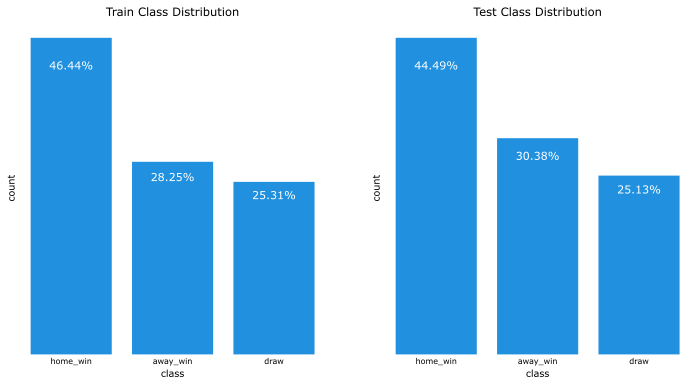

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
fig = sns.barplot(train_class_distribution,
                  x='class',
                  y='count',
                  color=default_blue)
hide_spines(fig)
annotate_bars(fig, percentage=True, offset_ratio=0.1)
plt.yticks([])
plt.title('Train Class Distribution')
plt.subplot(1, 2, 2)
plt.title('Test Class Distribution')
fig_2 = sns.barplot(test_class_distribution,
                    x='class',
                    y='count',
                    color=default_blue)
hide_spines(fig_2)
annotate_bars(fig_2, percentage=True, offset_ratio=0.1)
plt.yticks([])
plt.show()

- Having a look at the balance of our classes, we visualized the distributions for both the training and testing sets. The plots shows an imbalance of classes, with home wins occurring more frequently than away wins and draws.


- This balance of classes is important when selecting appropriate evaluation methods. In cases with pronounced class imbalances like ours, relying solely on accuracy as a metric can be misleading. For instance, a model that naively predicts 'home win' for every match could still achieve a decent accuracy score, despite its lack of true predictive insight.

In [19]:
# Initialize dummy classifier
dummy_classifier = DummyClassifier(strategy='stratified')

In [20]:
dummy_classifier.fit(X_train_scaled, y_train)

DummyClassifier(strategy='stratified')

In [21]:
y_pred = dummy_classifier.predict(X_test_scaled)

In [22]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.25      0.25      1335
           1       0.32      0.31      0.31      1614
           2       0.44      0.45      0.45      2364

    accuracy                           0.36      5313
   macro avg       0.34      0.34      0.34      5313
weighted avg       0.36      0.36      0.36      5313



- We have established a baseline model using the dummy classifier. We used the stratified type, which randomly assigns match outcomes (draw, away win, or home win) based on how frequently each of these outcomes occurred in the training data . This is useful because our dataset is a bit imbalanced, so just using the most frequent approach would lead us to results only favoring the most frequent class (home wins).


- We can see that all of our weighted average metrics are sitting around 35-36%, when we start developing our new models with new features, these are some of the metrics we will be comparing against. Later in the notebook we will talk about which metrics might be more valuable given the context of betting.

**Feature Creation/Engineering**

In [11]:
# Create rating differnence feature
match_w_features['rating_difference'] = abs(
    match_w_features['home_overall_rating'] -
    match_w_features['away_overall_rating'])
# Assign match outcome a value to compute rolling win pct
match_w_features['home_win'] = match_w_features['match_outcome'].apply(
    lambda x: 1 if x == 'home_win' else 0)
match_w_features['away_win'] = match_w_features['match_outcome'].apply(
    lambda x: 1 if x == 'away_win' else 0)
match_w_features['is_draw'] = match_w_features['match_outcome'].apply(
    lambda x: 1 if x == 'draw' else 0)

match_w_features['home_loss'] = match_w_features['match_outcome'].apply(
    lambda x: 1 if x == 'away_win' else 0)
match_w_features['away_loss'] = match_w_features['match_outcome'].apply(
    lambda x: 1 if x == 'home_win' else 0)

# Use our rolling function to create new features
# Computing rolling stats with a window of 3 (the stats from last 3 matches)
match_w_features['home_goals_rolling'] = compute_rolling_stats(
    match_w_features, 'home_team_api_id', 'home_team_goal')
match_w_features['away_goals_rolling'] = compute_rolling_stats(
    match_w_features, 'away_team_api_id', 'away_team_goal')

match_w_features['home_win_pct_rolling'] = compute_rolling_stats(
    match_w_features, 'home_team_api_id', 'home_win')
match_w_features['away_win_pct_rolling'] = compute_rolling_stats(
    match_w_features, 'home_team_api_id', 'away_win')

match_w_features['home_loss_pct_rolling'] = compute_rolling_stats(
    match_w_features, 'home_team_api_id', 'home_loss')
match_w_features['away_loss_pct_rolling'] = compute_rolling_stats(
    match_w_features, 'away_team_api_id', 'away_loss')

match_w_features['home_draw_pct_rolling'] = compute_rolling_stats(
    match_w_features, 'home_team_api_id', 'is_draw')
match_w_features['away_draw_pct_rolling'] = compute_rolling_stats(
    match_w_features, 'away_team_api_id', 'is_draw')
match_w_features = match_w_features.dropna(
    subset=['home_goals_rolling', 'away_goals_rolling'])

In [12]:
cutoff_date = pd.to_datetime('2014-06-30')
train = match_w_features[match_w_features['date'] < cutoff_date]
test = match_w_features[match_w_features['date'] >= cutoff_date]

In [13]:
# Features we will be using
features = [
    'home_overall_rating', 'away_overall_rating', 'rating_difference',
    'home_goals_rolling', 'away_goals_rolling', 'average_home_odds',
    'average_away_odds', 'average_draw_odds', 'home_win_pct_rolling',
    'away_win_pct_rolling', 'home_draw_pct_rolling', 'away_draw_pct_rolling',
    'home_loss_pct_rolling', 'away_loss_pct_rolling', 'home_stamina',
    'away_stamina', 'home_gk_handling', 'away_gk_handling'
]

target = 'match_outcome_encoded'

**Cross Validating Different Models**

In [15]:
# Using time series split for crossval
# This considers the time aspect and prevents data leakage
tscv = TimeSeriesSplit(n_splits=5)

X = train[features]
y = test[target]

X_train, X_test = train[features], test[features]
y_train, y_test = train[target], test[target]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
# We will be trying a range of different models
# To see which perform best
models = {
    'LogisticRegression':
    LogisticRegression(max_iter=1000,
                       class_weight='balanced',
                       multi_class='multinomial'),
    'RandomForest':
    RandomForestClassifier(n_estimators=100,
                           random_state=42,
                           class_weight='balanced'),
    'SVM':
    SVC(class_weight='balanced'),
    'KNN':
    KNeighborsClassifier()
}

In [70]:
# Initiate dictonary with model metrics
model_results = {}
# Loop through each model and cross validate
for model_name, model in models.items():
    cross_val = cross_validate(estimator=model,
                               X=X_train_scaled,
                               y=y_train,
                               cv=tscv,
                               scoring=scoring_metrics)
    model_results[model_name] = cross_val

In [71]:
log_reg = cross_validation_report_classifcation(
    model_results['LogisticRegression'])
random_forest = cross_validation_report_classifcation(
    model_results['RandomForest'])
svm = cross_validation_report_classifcation(model_results['SVM'])
knn = cross_validation_report_classifcation(model_results['KNN'])

In [73]:
model_metrics = pd.DataFrame(
    {
        "LogisticRegression": log_reg,
        'RandomForest': random_forest,
        'SVM': svm,
        'KNN': knn
    },
    index=['Accuracy', 'Precsion', 'Recall', 'F1_Score'])
model_metrics

,LogisticRegression,RandomForest,SVM,KNN
Accuracy,47.821,51.908,47.975,43.743
Precsion,50.472,47.183,49.764,44.204
Recall,47.821,51.908,47.975,43.743
F1_Score,48.429,46.790,48.590,43.878


- After cross validating a few different models we have a resulting data frame with the weighted average metrics for each model. From a betting companies perspective, an important metric for us will be precision. Why? Precision tells us how often the model's predictions of specific outcomes (like a home win) are correct. High precision means fewer false positives, which is key in betting since incorrect predictions (false positives) can lead to financial losses.


- Recall can also be considered important metric which tells us the models ability to correctly identify each class. From a betting perspective, higher recall means the model effectively identifies most actual winning bets, ensuring minimal missed opportunities for profitable wagers.

**Logistic Regression**

In [16]:
# Out of all 4 models Logistic Regression performed best
log_reg_model = LogisticRegression(class_weight='balanced',
                                   multi_class='multinomial',
                                   random_state=42)
log_reg_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=42)

In [17]:
y_probas = log_reg_model.predict_proba(X_test_scaled)
y_pred_log_reg = log_reg_model.predict(X_test_scaled)
report_log_reg = classification_report(y_test, y_pred_log_reg)
print(report_log_reg)

              precision    recall  f1-score   support

           0       0.31      0.39      0.35      1294
           1       0.49      0.54      0.51      1575
           2       0.66      0.51      0.58      2313

    accuracy                           0.49      5182
   macro avg       0.49      0.48      0.48      5182
weighted avg       0.52      0.49      0.50      5182



In [19]:
conf_matrix_log_reg = pd.DataFrame(
    confusion_matrix(y_test, y_pred_log_reg),
    index=['actual_draw', 'actual_away_win', 'actual_home_win'],
    columns=['predicted_draw', 'predicted_away_win', 'predicted_home_win'])

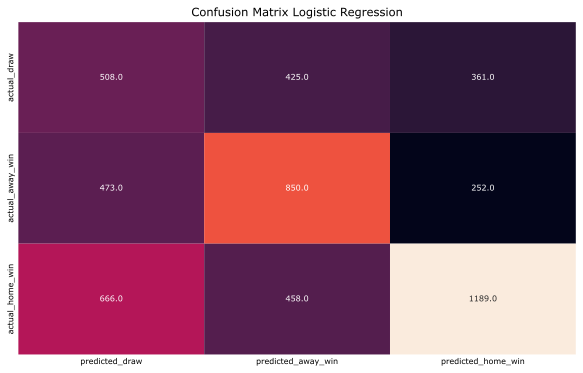

In [24]:
plt.figure(figsize=(10, 6))
plt.title('Confusion Matrix Logistic Regression')
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='0.1f', cbar=False)
plt.show()

- After testing a few models, the Logistic Regression model performed the best. To evaluate further we the  model and were able to get a break down class by class to see how the model performs for given class (home win,away win,etc).


- Having a look at our classification report for our Logistic Regression model, we can see our precision for predicting draws is around 31%, away wins is 49% and home wins is 66%. Recall scores for draws is 43%, away wins is 51% and home wins is 50%. Comparing these results to our baseline model we can see that the results are superior.


- Our confusion matrix for our Logistic Regression model, displays the model is best at predicting home wins, as indicated by the highest number of correct predictions  in the actual_home_win row. The model struggles the most with correctly predicting draws, as there are a number of instances misclassified as either away wins or home wins. Predictions for away wins are more accurate than for draws but less accurate than for home wins.

**Hyper Parameter Tuning**

In [59]:
scorer = make_scorer(precision_score, average='weighted')

In [98]:
param_grid_log = {
    'C': [0.001, 0.01, 0.02, 0.03],  # : Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # Solver to use
    'max_iter': [100, 200, 300],  # Maximum number of iterations for solvers
    'fit_intercept': [True, False]  # Whether to calculate the intercept or not
}

In [81]:
grid_search = GridSearchCV(estimator=log_reg_model,
                           param_grid=param_grid_log,
                           scoring=scorer,
                           cv=tscv)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LogisticRegression(class_weight='balanced',
                                          multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': [0.001, 0.01, 0.02, 0.03],
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 300],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring=make_scorer(precision_score, average=weighted))

In [83]:
print("Best Parameters:", grid_search.best_params_)
print("Best Weighted Average Precision:", grid_search.best_score_)

Best Parameters: {'C': 0.001, 'fit_intercept': True, 'max_iter': 100, 'solver': 'newton-cg'}
Best Weighted Average Precision: 0.5082770212430722


In [113]:
log_reg_tuned = LogisticRegression(class_weight='balanced',
                                   multi_class='multinomial',
                                   C=0.001,
                                   max_iter=100,
                                   solver='newton-cg',
                                   fit_intercept=True)

In [114]:
log_reg_tuned.fit(X_train_scaled, y_train)

LogisticRegression(C=0.001, class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg')

In [116]:
y_probas_tuned = log_reg_tuned.predict_proba(X_test_scaled)
log_reg_tuned_pred = log_reg_tuned.predict(X_test_scaled)
log_reg_tuned_report = classification_report(y_test, log_reg_tuned_pred)
print(log_reg_tuned_report)

              precision    recall  f1-score   support

           0       0.30      0.41      0.35      1294
           1       0.50      0.53      0.52      1575
           2       0.66      0.50      0.57      2313

    accuracy                           0.49      5182
   macro avg       0.49      0.48      0.48      5182
weighted avg       0.52      0.49      0.50      5182



- After tunining some hyper parameters using Gridsearch and cross validation, which simply said, will search through various different combinations of these hyper parameters and try to return the optimal parameters that optimize our metric at hand. Since we were focused more on precision we used that. We can see that for our Logistic Regression model the precision has increased by 1 percent for class 1 (away wins).


- So overall we managed to get a decent model, that being said there is always room for improvement. When it comes to something like predicting football games, it can be a very complex task because there is many moving parts that come into play when trying to make predictions.

### Predicting Number Of Goals 

**Baseline Models**

In [430]:
dummy_features = ['home_overall_rating', 'average_home_odds']
target_home = 'home_team_goal'
target_away = 'away_team_goal'

In [431]:
cutoff_date = pd.to_datetime('2014-06-30')
train = match_w_features[match_w_features['date'] < cutoff_date]
test = match_w_features[match_w_features['date'] >= cutoff_date]

In [432]:
X = train[features]
y = test[target]

X_train, X_test = train[dummy_features], test[dummy_features]
y_train, y_test = train[target_home], test[target_home]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [433]:
dummy_regr_home = DummyRegressor(strategy="mean")
dummy_regr_home.fit(X_train_scaled, y_train)

DummyRegressor()

In [434]:
y_pred_dummy = np.round(dummy_regr.predict(X_test))
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
rmse_dummy = np.sqrt(mse_dummy)
print(f"Mean Squared Error: {mse_dummy}")
print(f"Root Mean Squared Error: {rmse_dummy}")

Mean Squared Error: 1.938054805094558
Root Mean Squared Error: 1.3921403683158384


In [435]:
X = train[dummy_features]
y = test[target_away]

X_train, X_test = train[dummy_features], test[dummy_features]
y_train, y_test = train[target_away], test[target_away]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [436]:
dummy_regr_away = DummyRegressor(strategy="mean")
dummy_regr_away.fit(X_train_scaled, y_train)

DummyRegressor()

In [437]:
y_pred_dummy = np.round(dummy_regr.predict(X_test))
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
rmse_dummy = np.sqrt(mse_dummy)
print(f"Mean Squared Error: {mse_dummy}")
print(f"Root Mean Squared Error: {rmse_dummy}")

Mean Squared Error: 2.0152450791200307
Root Mean Squared Error: 1.4195932794712824


- We have created two baseline models using the dummy regressor with the strategy set to mean for predicting home team goals and away team goals. The 'mean' strategy will just predict the average number of goals based on the training set for every match. This helps us establish some baseline scores to compare against for when we move onto more complex models.


- MSE and RMSE are both metrics that measure error but in slightly different ways. MSE measures the average squared difference between the actual outcomes and the predictions made by the model. RMSE is just the square root of MSE which means it's in the same units as your dependent variable (easier to interpret).

**Testing Models**

In [119]:
# Features
features = [
    'home_overall_rating', 'away_overall_rating', 'home_goals_rolling',
    'away_goals_rolling', 'average_home_odds', 'average_away_odds',
    'average_draw_odds', 'home_finishing', 'home_free_kick_accuracy',
    'home_short_passing', 'home_ball_control', 'home_dribbling',
    'home_heading_accuracy', 'home_volleys', 'home_long_passing',
    'home_sprint_speed', 'home_shot_power', 'home_aggression',
    'home_interceptions', 'away_finishing', 'away_free_kick_accuracy',
    'away_short_passing', 'away_ball_control', 'away_dribbling',
    'away_heading_accuracy', 'away_volleys', 'away_long_passing',
    'away_sprint_speed', 'away_shot_power', 'away_aggression',
    'away_interceptions'
]

home_target = 'home_team_goal'
away_target = 'away_team_goal'

In [120]:
cutoff_date = pd.to_datetime('2014-06-30')
train = match_w_features[match_w_features['date'] < cutoff_date]
test = match_w_features[match_w_features['date'] >= cutoff_date]

In [121]:
# Split for home goals model
X_home = train[features]
y_home = test[home_target]

X_train_home, X_test_home = train[features], test[features]
y_train_home, y_test_home = train[home_target], test[home_target]

In [642]:
scoring_reg = {'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'}
models_goal_pred = {
    'RandomForestRegressor':
    RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoostingRegressor':
    GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [801]:
model_results_reg_home = {}
for model_name, model in models_goal_pred.items():
    cross_val = cross_validate(estimator=model,
                               X=X_train_home,
                               y=y_train_home,
                               cv=tscv,
                               scoring=scoring_reg)
    model_results_reg_home[model_name] = cross_val

In [802]:
rf_reg_home = cross_val_report_lin_reg(
    model_results_reg_home['RandomForestRegressor'])
gb_reg_home = cross_val_report_lin_reg(
    model_results_reg_home['GradientBoostingRegressor'])
model_scores_reg_home = pd.DataFrame(
    {
        'RandomForestRegressor': rf_reg_home,
        'GradientBoostingRegressor': gb_reg_home
    },
    index=['R2', 'MSE', 'RMSE'])

In [125]:
# Split for away goals model
X_away = train[features]
y_away = test[away_target]

X_train_away, X_test_away = train[features], test[features]
y_train_away, y_test_away = train[away_target], test[away_target]

In [651]:
# Initiate dictonary with model metrics
model_results_reg_away = {}
# Loop through each model and cross validate
for model_name, model in models_goal_pred.items():
    cross_val = cross_validate(estimator=model,
                               X=X_train_away,
                               y=y_train_away,
                               cv=tscv,
                               scoring=scoring_reg)
    model_results_reg_away[model_name] = cross_val

In [653]:
rf_reg_away = cross_val_report_lin_reg(
    model_results_reg_away['RandomForestRegressor'])
gb_reg_away = cross_val_report_lin_reg(
    model_results_reg_away['GradientBoostingRegressor'])

In [655]:
model_scores_reg_away = pd.DataFrame(
    {
        'RandomForestRegressor': rf_reg_away,
        'GradientBoostingRegressor': gb_reg_away
    },
    index=['R2', 'MSE', 'RMSE'])

In [820]:
print('Home Goals Model')
print(model_scores_reg_home)
print('------------------------------------------------------')
print('Away Goals Model')
print(model_scores_reg_away)

Home Goals Model
      RandomForestRegressor  GradientBoostingRegressor
R2                 0.116223                   0.133590
MSE                1.541764                   1.511463
RMSE               1.241678                   1.229416
------------------------------------------------------
Away Goals Model
      RandomForestRegressor  GradientBoostingRegressor
R2                 0.066010                   0.086974
MSE                1.245842                   1.217686
RMSE               1.116173                   1.103488


- Since linear regression would not be a good fit for this scenario due to the assumptions of normally distributed residuals and continuous predictor values, I decided to test two regression models that don't rely on those assumptions and can handle more complex non linear relationships then standard linear regression.


- We used cross validation for both models (home and away goals). The results were, in our model to predict home goals the R-squared for Random Forest Regressor was 0.10 and the RMSE was 1.24. The Gradient Boosting model  yielded a higher R-squared and a slight bit lower RMSE.


- For our away goals model we can see a similar pattern where the gradient boosting model performed better. That being said we can see the R-squared values are very low. That tells us the proportion of variance in our target variable (away goals) thats explained by our features. Now we do see that the MSE AND RMSE are very close to the home goals model.


- Moving forward we will be using the Gradient Boosting model as it was performing best.

**Gradient Boosting Regressor**

In [122]:
# Fitting the home goals model
gb_home = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_home.fit(X_train_home, y_train_home)

GradientBoostingRegressor(random_state=42)

In [123]:
y_pred_home = np.round(gb_home.predict(X_test_home))
mse = mean_squared_error(y_test_home, y_pred_home)
rmse = np.sqrt(mean_squared_error(y_test_home, y_pred_home))
r_squared_home = r2_score(y_test_home, y_pred_home)
print(f"Mean Squared Error(Home Goals): {mse}")
print(f"Root Mean Squared Error(Home Goals): {rmse}")
print(f"R-Squared Error(Home Goals): {r_squared_home}")

Mean Squared Error(Home Goals): 1.5202624469316866
Root Mean Squared Error(Home Goals): 1.2329892322853784
R-Squared Error(Home Goals): 0.11283091649322807


In [126]:
# Fitting the away goals model
gb_away = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_away.fit(X_train_away, y_train_away)

GradientBoostingRegressor(random_state=42)

In [127]:
y_pred_away = np.round(gb_away.predict(X_test_away))
mse = mean_squared_error(y_test_away, y_pred_away)
rmse = np.sqrt(mean_squared_error(y_test_away, y_pred_away))
r_squared_away = r2_score(y_test_away, y_pred_away)
print(f"Mean Squared Error(Away Goals): {mse}")
print(f"Root Mean Squared Error(Away Goals): {rmse}")
print(f"R-Squared Error(Away Goals): {r_squared_away}")

Mean Squared Error(Away Goals): 1.2935160169818603
Root Mean Squared Error(Away Goals): 1.1373284560679295
R-Squared Error(Away Goals): 0.0435271941185712


- Just to note, we had tried different combinations of features and in the end the resulting features we chose to use performed the best. Overall we had hard time achieving good results for this task. This can be due to the complexity of predicting the number of goals, as well as the fact that a lot of games might end up with 0 goals. Overall we tried our best to model the relationship between our features and number of goals.


- After fitting our models we can see the final results. For predicting home goals we had an R-squared of 11%, MSE of 1.52 and RMSE of 1.23. So we can say on average our predictions deviate around 1.23 goals from the actual number of goals, which is not perfect but its something. For our away goals model we something interesting where the R-squared around 0.04 but MSE was 1.29 and RMSE was around 1.13.